# Spectrum estimation
Trovate qua sotto tutta la mia analisi commentata per la stima degli spettri. Ci concentreremo sul generatore 2 e considereremo 3 casisitiche: alta, bassa e media inerzia. Gli spettri saranno calcolati prima e dopo lo step (Ta va da 0.1s a 160s in ciascuno dei tre CIG)
La rete usata è la IEEE 39 bus del New England.
L'inerzia è stata modificata usando il generatore 1 (rest of the word) che ha una S=10e9 VA, contro quella degli altri che è sull'ordine di 1000MVA

Alta inerzia H = 10

Media inerzia H = 5 (standard per gen 1)

Bassa inerzia H = 2.5

Useremo una time series di 400 sec (in aggiunta al tempo necessario per raggiungere la stazionarietà).

## Import e caricamento dati

In [4]:
import os
import numpy as np
import json
from matplotlib import pyplot as plt
import scipy as sp
import spectrum
from scipy.signal import welch
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import pacf, acf

In [5]:
#caricamento simulazioni transienti
path_folder = "C:\\Users\\aless\\Desktop\\prova_non_param\\config"
# non parametric estimation using rectangular window (size = 100 sec)
fs = 200
start = 150*fs
stop = start + 400*fs
dati = {}
dati['h_base'] = np.load(os.path.join(path_folder, 'high_h_base.npz'), allow_pickle = True)
dati['h_step'] = np.load(os.path.join(path_folder, 'high_h_mid_step.npz'), allow_pickle = True)

dati['m_base'] = np.load(os.path.join(path_folder, 'mid_h_base.npz'), allow_pickle = True)
dati['m_step'] = np.load(os.path.join(path_folder, 'mid_h_mid_step.npz'), allow_pickle = True)

dati['l_base'] = np.load(os.path.join(path_folder, 'low_h_base.npz'), allow_pickle = True)
dati['l_step'] = np.load(os.path.join(path_folder, 'low_h_mid_step.npz'), allow_pickle = True)
signals = {}
print(list(dati['h_base'].keys()))
for k in dati.keys():
    print(dati[k]['H'])
    signals[k] = {}
    signals[k]['omega_total'] = dati[k]['data'].item()['gen']['s:xspeed'][:,2]
    signals[k]['omega_original'] = sp.signal.detrend(signals[k]['omega_total'][start:stop])

['config', 'seed', 'OU_seeds', 'inertia', 'energy', 'momentum', 'Stot', 'H', 'S', 'J', 'Psm', 'Qsm', 'Psg', 'Qsg', 'Pload', 'Qload', 'PF_with_slack', 'PF_without_slack', 'time', 'data', 'attributes', 'device_names', 'ref_SMs']
{'G 01': 10.0, 'G 02': 4.329999923706055, 'G 03': 4.46999979019165, 'G 04': 3.569999933242798, 'G 05': 4.329999923706055, 'G 06': 4.349999904632568, 'G 07': 3.7700002193450928, 'G 08': 3.4699997901916504, 'G 09': 3.450000047683716, 'G 10': 4.199999809265137}
{'G 01': 10.0, 'G 02': 4.329999923706055, 'G 03': 4.46999979019165, 'G 04': 3.569999933242798, 'G 05': 4.329999923706055, 'G 06': 4.349999904632568, 'G 07': 3.7700002193450928, 'G 08': 3.4699997901916504, 'G 09': 3.450000047683716, 'G 10': 4.199999809265137}
{'G 01': 5.0, 'G 02': 4.329999923706055, 'G 03': 4.46999979019165, 'G 04': 3.569999933242798, 'G 05': 4.329999923706055, 'G 06': 4.349999904632568, 'G 07': 3.7700002193450928, 'G 08': 3.4699997901916504, 'G 09': 3.450000047683716, 'G 10': 4.19999980926513

In [6]:
#caricamento risultati da jacobiani da usare come reference
dati_clean = {}
dati_clean['l_base']= np.load("C:\\Users\\aless\\Desktop\\prova_non_param\\config\\jacobiani\low\\IEEE39_stoch_CIG_AC_TF_-3.0_2.0_100.npz", allow_pickle = True)
dati_clean['m_base']= np.load("C:\\Users\\aless\\Desktop\\prova_non_param\\config\\jacobiani\mid\\IEEE39_stoch_CIG_AC_TF_-3.0_2.0_100.npz", allow_pickle = True)
dati_clean['h_base']  = np.load("C:\\Users\\aless\\Desktop\\prova_non_param\\config\\jacobiani\high\\IEEE39_stoch_CIG_AC_TF_-3.0_2.0_100.npz", allow_pickle = True)

dati_clean['l_step'] = np.load("C:\\Users\\aless\\Desktop\\prova_non_param\\config\\jacobiani\low_h_mid_step\\IEEE39_stoch_CIG_AC_TF_-3.0_2.0_100.npz", allow_pickle = True)
dati_clean['m_step']= np.load("C:\\Users\\aless\\Desktop\\prova_non_param\\config\\jacobiani\mid_h_mid_step\\IEEE39_stoch_CIG_AC_TF_-3.0_2.0_100.npz", allow_pickle = True)
dati_clean['h_step'] = np.load("C:\\Users\\aless\\Desktop\\prova_non_param\\config\\jacobiani\high_h_mid_step\\IEEE39_stoch_CIG_AC_TF_-3.0_2.0_100.npz", allow_pickle = True)
for k in dati_clean.keys():
    print(k)
    print(dati_clean[k]['H'][0])
    value = np.nonzero(dati_clean[k]['var_names'] == 'G 03.speed')
    print(value)
    signals[k]['spettro_clean'] = 20*np.log10(np.squeeze(abs(dati_clean[k]['TF'][0,:, value] + dati_clean[k]['TF'][1,:, value])))


l_base
2.5
(array([158], dtype=int64),)
m_base
5.0
(array([158], dtype=int64),)
h_base
10.0
(array([158], dtype=int64),)
l_step
2.5
(array([158], dtype=int64),)
m_step
5.0
(array([158], dtype=int64),)
h_step
10.0
(array([158], dtype=int64),)


Plotto gli spettri ottenuti tramite analisi AC

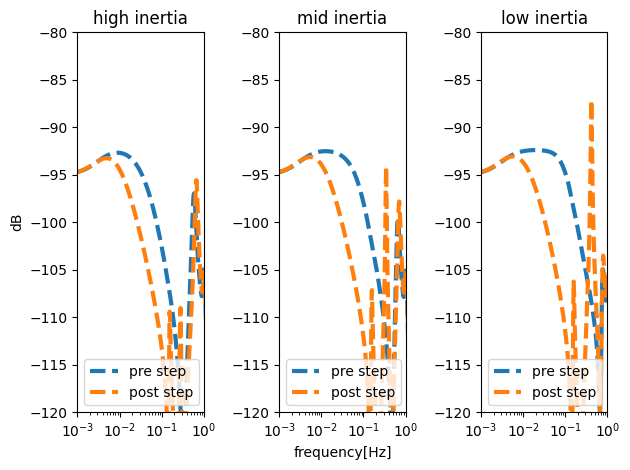

In [10]:
fig, axs = plt.subplots(1,3)
xlim = (0.001, 1)
ylim = (-120, -80)

axs[0].semilogx(dati_clean['h_base']['F'], signals['h_base']['spettro_clean'], linestyle = '--', label ='pre step', linewidth = 3)
axs[0].semilogx(dati_clean['h_step']['F'], signals['h_step']['spettro_clean'], linestyle = '--', label ='post step', linewidth = 3)
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].set_ylabel('dB')
axs[0].set_title('high inertia')
axs[0].legend(loc = 'lower left')

axs[1].semilogx(dati_clean['m_base']['F'], signals['m_base']['spettro_clean'], linestyle = '--', label ='pre step', linewidth = 3)
axs[1].semilogx(dati_clean['m_step']['F'], signals['m_step']['spettro_clean'], linestyle = '--', label ='post step', linewidth = 3)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].set_xlabel('frequency[Hz]')
axs[1].set_title('mid inertia')
axs[1].legend(loc = 'lower left')


axs[2].semilogx(dati_clean['l_base']['F'], signals['l_base']['spettro_clean'], linestyle = '--', label ='pre step', linewidth = 3)
axs[2].semilogx(dati_clean['l_step']['F'], signals['l_step']['spettro_clean'], linestyle = '--', label ='post step', linewidth = 3)
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
axs[2].set_title('low inertia')
axs[2].legend(loc = 'lower left')

plt.tight_layout()
plt.show()


In [15]:
#funzine per ottenere facilmente i grafici
def plotter(signals, what_to_show, title):
    fig, axs = plt.subplots(1,3, figsize=(10,5))
    xlim = (0.001, 1)
    ylim = (-120, -80)
    axs[0].semilogx(dati_clean['h_base']['F'], signals['h_base']['spettro_clean'], color = 'b', linestyle = '--', 
                    label ='J base', linewidth = 3)
    axs[0].semilogx(dati_clean['h_step']['F'], signals['h_step']['spettro_clean'], color = 'orange', linestyle = '--',
                    label ='J step', linewidth = 3)
    axs[0].semilogx(signals['h_base']['F'], signals['h_base'][what_to_show ], color = 'b', linestyle = '-', 
                    label ='stima base', linewidth = 3)
    axs[0].semilogx(signals['h_step']['F'], signals['h_step'][what_to_show ],color = 'orange', linestyle = '-', 
                    label ='stima step', linewidth = 3)
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)
    axs[0].set_title('high inertia')
    axs[0].legend(loc = 'upper left')

    axs[1].semilogx(dati_clean['m_base']['F'], signals['m_base']['spettro_clean'], color = 'b', linestyle = '--', 
                    label ='J base', linewidth = 3)
    axs[1].semilogx(dati_clean['m_step']['F'], signals['m_step']['spettro_clean'], color = 'orange', linestyle = '--',
                    label ='J step', linewidth = 3)
    axs[1].semilogx(signals['m_base']['F'], signals['m_base'][what_to_show ], color = 'b', linestyle = '-', 
                    label ='stima base', linewidth = 3)
    axs[1].semilogx(signals['m_step']['F'], signals['m_step'][what_to_show ],color = 'orange', linestyle = '-', 
                    label ='stima step', linewidth = 3)
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)
    axs[1].set_title('mid inertia')
    axs[1].legend(loc = 'upper left')

    axs[2].semilogx(dati_clean['l_base']['F'], signals['l_base']['spettro_clean'], color = 'b', linestyle = '--', 
                    label ='J base', linewidth = 3)
    axs[2].semilogx(dati_clean['l_step']['F'], signals['l_step']['spettro_clean'], color = 'orange', linestyle = '--',
                    label ='J step', linewidth = 3)
    axs[2].semilogx(signals['l_base']['F'], signals['l_base'][what_to_show ], color = 'b', linestyle = '-', 
                    label ='stima base', linewidth = 3)
    axs[2].semilogx(signals['l_step']['F'], signals['l_step'][what_to_show ],color = 'orange', linestyle = '-', 
                    label ='stima step', linewidth = 3)
    axs[2].set_xlim(xlim)
    axs[2].set_ylim(ylim)
    axs[2].set_title('low inertia')
    axs[2].legend(loc = 'upper left')
    plt.suptitle(title)
    plt.show()

## Stime non parametriche

Viene usato il metodo di Welch. Iniziamo con finestra rettangolare. Corrisponde al metodo di Bartlett

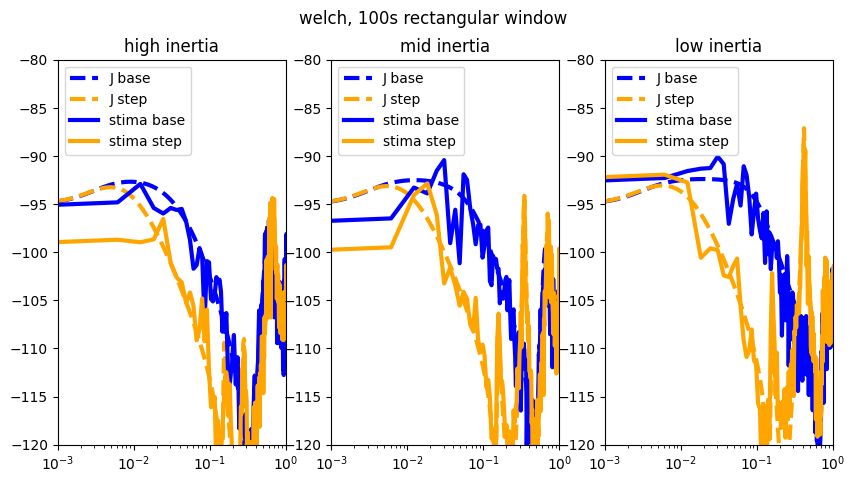

In [16]:
for k in signals.keys():
    signals[k]['F'], signals[k]['spettro_boxcar'] =  welch(signals[k]['omega_original'],
                     scaling = 'density', fs = 200, nperseg = fs*100, window = 'boxcar', noverlap =0, nfft = 2**15)
    signals[k]['spettro_boxcar'] = 10*np.log10(abs(signals[k]['spettro_boxcar']))
plotter(signals, 'spettro_boxcar', 'welch, 100s rectangular window')

Text(0, 0.5, 'dB')

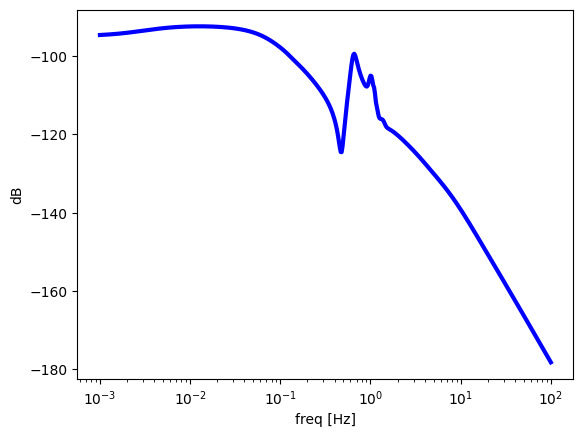

In [17]:
plt.semilogx(dati_clean['l_base']['F'], signals['m_base']['spettro_clean'], color = 'b', linestyle = '-', 
                    label ='stima base', linewidth = 3)
plt.xlabel('freq [Hz]')
plt.ylabel('dB')

Passiamo quindi alla finestra di hamming. NB la finestra di hamming causa una minore risoluzione spaziale (circa la metà della rettangolare) ma offre un minore spectral leakage e la possibilità di sovrapporre gli intervalli ottenendone di più

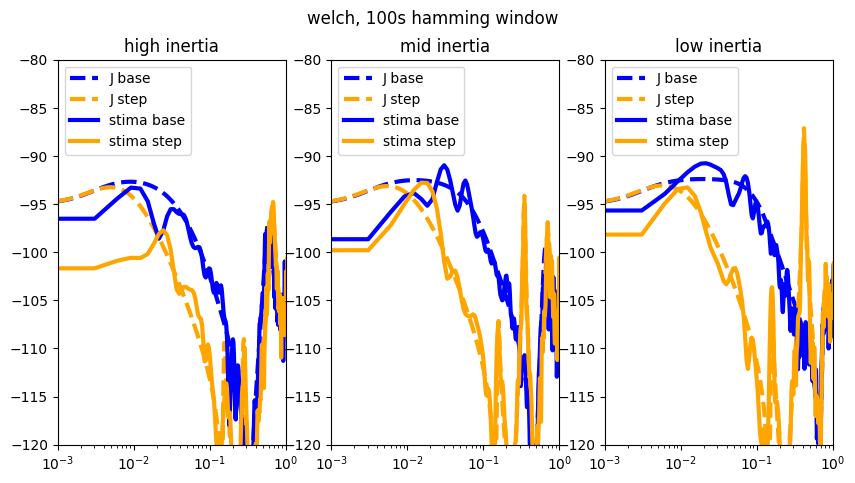

In [17]:
# non parametric estimation using hamm window (size = 150 sec, overlap 50%)

for k in signals.keys():
    signals[k]['F'], signals[k]['spettro_hamm'] =  welch(signals[k]['omega_original'],
                     scaling = 'density', fs = 200, nperseg = fs*100, window = 'hamm', noverlap =None, nfft = 2**16)
    signals[k]['spettro_hamm'] = 10*np.log10(abs(signals[k]['spettro_hamm']))
plotter(signals, 'spettro_hamm', 'welch, 100s hamming window')

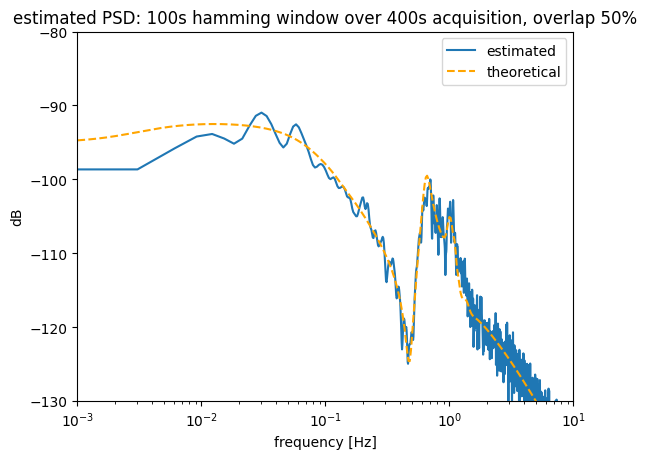

In [23]:
k = 'm_base'
plt.semilogx( signals[k]['F'], signals[k]['spettro_hamm'], label = 'estimated')
plt.semilogx(dati_clean['m_step']['F'], signals['m_base']['spettro_clean'], color = 'orange', linestyle = '--',
                    label ='theoretical')
plt.ylim([-130, -80])
plt.xlim([1e-3, 10])
plt.title('estimated PSD: 100s hamming window over 400s acquisition, overlap 50%')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB')
plt.legend()

In [24]:
tau = 20e-3
alpha= 1/tau
c = 1.3*np.sqrt(2*alpha)
F = np.logspace(-3, 2, 501)
PSD = np.sqrt((c/alpha)**2 / (1 + (2*np.pi*F/alpha)**2))

In [30]:
c


13.0

Text(0.5, 1.0, 'theoretical spectrum of a OU process')

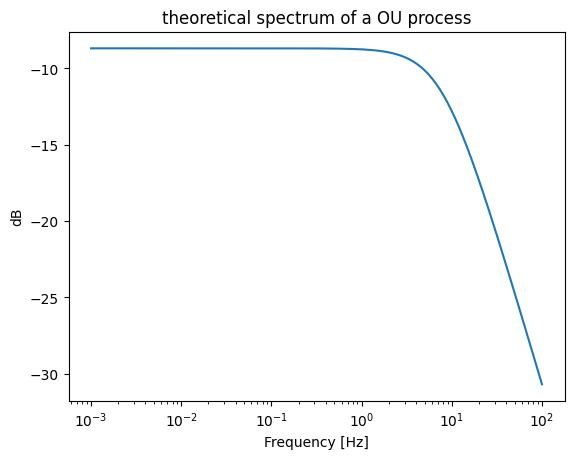

In [28]:
plt.semilogx(F, 10*np.log10(2*(PSD**2)))
plt.xlabel('Frequency [Hz]')
plt.ylabel('dB')
plt.title('theoretical spectrum of a OU process')

Adesso procedo a effettuare un downsample del segnale per isolare la banda di frequenza di interesse (ovvero sotto lo 0.2Hz). Un filtro iir evita l'aliasing. Dato che non ci interessa la forma del segnale posso usare anche filtri a fase non lineare.
In particolare diminuiamo la frequenza di campionamento di 500 volte (da 200Hz a 0.4Hz)

(20,)


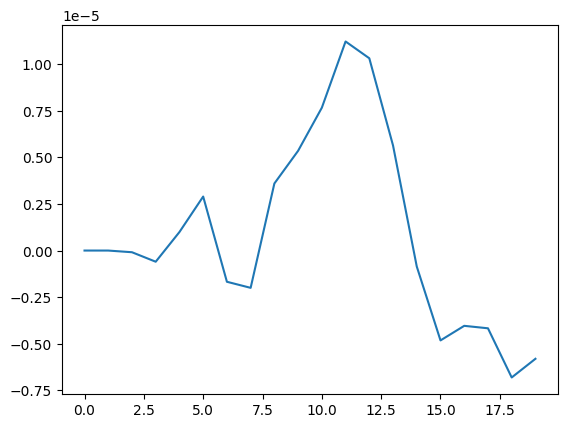

In [4]:
#apply downsampling to cut undesired frequency band
for k in signals.keys():
    #in tre volte perché la documentazione suggerisce di fare così quando il rapporto di downsampling è molto alto
    signals[k]['omega_downsample'] = sp.signal.decimate(signals[k]['omega_original'][start:stop], 10, ftype = 'iir', axis = 0, zero_phase = False)
    signals[k]['omega_downsample'] = sp.signal.decimate(signals[k]['omega_downsample'], 10, ftype = 'iir', axis = 0, zero_phase = False)
    signals[k]['omega_downsample'] = sp.signal.decimate(signals[k]['omega_downsample'], 5, ftype = 'iir', axis = 0, zero_phase = False)
print(signals['h_base']['omega_downsample'].shape)
plt.plot(signals['h_base']['omega_downsample'])

Per alleggerire il notebook ho tolto alcune analisi che avevo fatto. In generale il risultato del downsampling è identico per ciascun generatore. Inoltre fare la media delle time series non produce spettri migliori

In [5]:
fs_new = 0.4
for k in signals.keys():
    signals[k]['F'], signals[k]['spettro_undersampling'] =  welch(signals[k]['omega_downsample'],
                     scaling = 'density', fs = fs_new, nperseg = fs_new*100, window = 'hamm', noverlap =None)
    signals[k]['spettro_undersampling'] = 10*np.log10(abs(signals[k]['spettro_undersampling']))
plotter(signals, 'spettro_undersampling', 'welch, 100s hamming window after undersample to 0.4Hz')

c:\Users\aless\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 40 is greater than input length  = 20, using nperseg = 20
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


NameError: name 'plotter' is not defined

## Stime parametriche
Andiamo a cercare un modello ARMA (Auto Regressive Moving Average) che sia una buona stima del modello reale e ne calcoleremo lo spettro
Per prima cosa osserviamo gli spettri di riferimento (jacobiani) su una scala non logaritmica. Noteremo che la caratteristica principale è un picco quindi già un modello AR(1) potrebbe essere in grado di fornirci una buona stima

(0.001, 0.1)

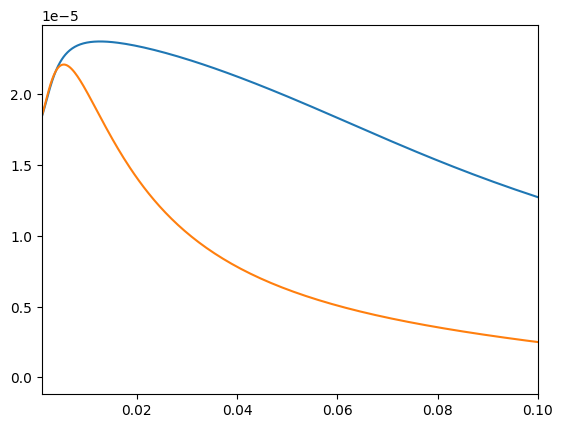

In [22]:
plt.plot(dati_clean['h_base']['F'], 10**(signals['m_base']['spettro_clean']/20))
plt.plot(dati_clean['h_base']['F'], 10**(signals['m_step']['spettro_clean']/20))
plt.xlim(0.001, 0.1)

Plottiamo le funzioni autocorrelazione e di autocorrelazione parziale per andare a fare una prima stima dell'ordine del modello.

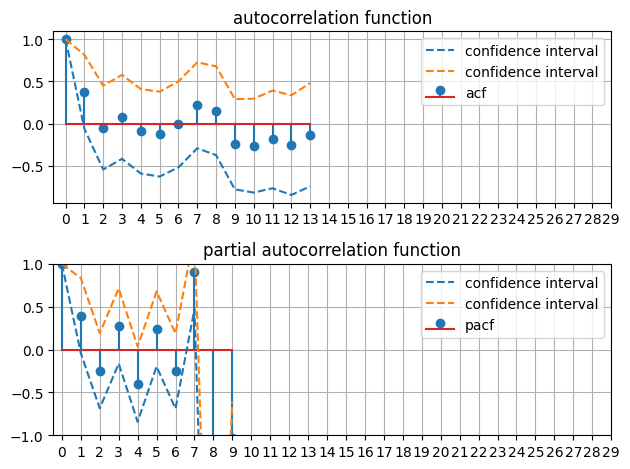

In [7]:
x = signals['m_base']['omega_downsample']
pacf_values, pacf_confint = pacf(x, method='ywadjusted', alpha=0.05)
acf_values, acf_confint = acf(x, alpha = 0.05, bartlett_confint=True)

fig, axs = plt.subplots(2,1)
axs[0].stem(acf_values, label='acf')
axs[0].plot(acf_confint, linestyle='--', label = 'confidence interval')
axs[0].grid()
axs[0].set_title('autocorrelation function')
axs[0].set_xticks(np.arange(0, 30))
axs[0].legend()

axs[1].stem(pacf_values, label='pacf')
axs[1].plot(pacf_confint, linestyle='--', label = 'confidence interval')
axs[1].grid()
axs[1].set_title('partial autocorrelation function')
axs[1].set_xticks(np.arange(0, 30))
axs[1].set_ylim([-1, 1])
axs[1].legend()
plt.tight_layout()



L'andamento oscillatorio della funzione di autocorrelazione parziale unita al veloce smorzamento della acf indicano che il processo è di tipo MA con un ordine basso (da 3 in giù sospetto). 

Iniziamo applicando il criterio di Akaike per valutare il miglior ordine per un modello MA (sarebbe nato per i modelli autoregressivi ma molti manuali di teoria lo suggeriscono in generale per qualunque ARMA)

Text(0, 0.5, 'AIC value')

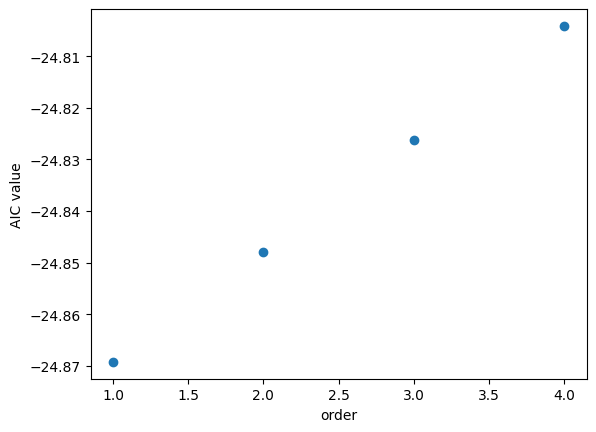

In [173]:
#let's see the akaike information criteria
order = np.arange(1, 5)
ma_list = []
rho_list = []
for i in order:
    ma, rho = spectrum.ma(x,i, M=20) 
    ma_list.append(ma)
    rho_list.append(rho)
plt.scatter(order, spectrum.AICc(len(x), rho_list, order), label='AICc')
plt.xlabel('order')
plt.ylabel('AIC value')


proviamo a vedere uno spettro con un modello MA(1)

(-120.0, -80.0)

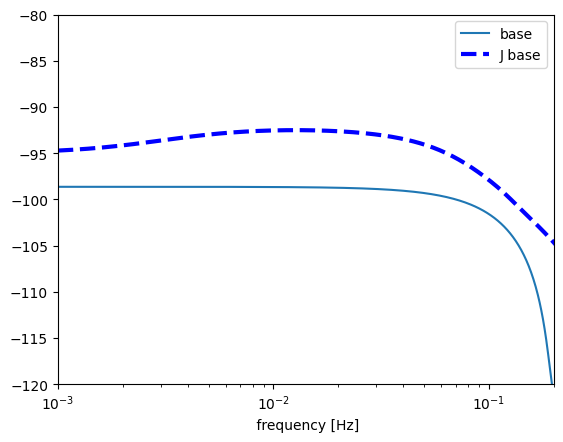

In [12]:
order = 1
ma_base, rho_base= spectrum.ma(x, Q = order, M =10)
PSD_base = spectrum.arma2psd(A = None, B = ma_base, rho = rho_base, T = 0.4, NFFT=512) 
PSD_base = PSD_base[:len(PSD_base)//2]*2 #per convenzione se diemzzo l'intervallo devo raddoppiare i valori così 
                                        #l'area sottesa corrisponde sempre alla variaza totale
plt.semilogx(np.linspace(0, 0.2, len(PSD_base)),10*np.log10(abs(PSD_base)),label='base')
#plt.plot(np.linspace(0, 0.2, len(PSD_base)), abs(PSD_base)),
 #   label='base')

plt.semilogx(dati_clean['m_base']['F'], signals['m_base']['spettro_clean'], color = 'b', linestyle = '--', label ='J base', linewidth = 3)

plt.xlabel(' frequency [Hz]')
plt.legend() 
plt.xlim(0.001, 0.2)
plt.ylim([-120, -80])

La stima non è pessima ma possiamo vedere se c'è di meglio. Possiamo sfruttare il fatto che ci aspettiamo uno spettro con un certo picco. Possiamo ipotizzare che il processo sia autoregressivo con un ordine vicino a 1.
Vediamo se usando il metodo di Burg unitamente al criterio di Akaike possiamo trovare l'ordine corretto 

In [123]:
AR, P, k = spectrum.arburg(x,order = 10, criteria ='AKICc')
print('the best order appear to be {}'.format(AR.shape))

the best order appear to be (2,)


Ripetiamo quanto fatto sopra

(-120.0, -80.0)

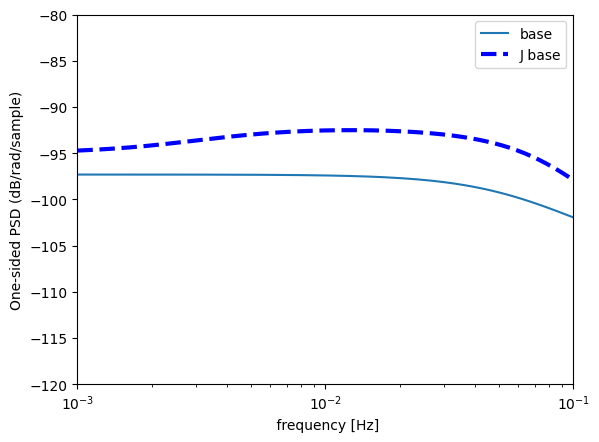

In [11]:
order = 1
ar_base, rho_base, k= spectrum.arburg(x, order =order)
PSD_base = spectrum.arma2psd(A = ar_base, B = None, rho = rho_base, T = 0.4, NFFT=512) 
PSD_base = PSD_base[:len(PSD_base)//2]*2 #per convenzione se diemzzo l'intervallo devo raddoppiare i valori così 
                                        #l'area sottesa corrisponde sempre alla variaza totale
plt.semilogx(np.linspace(0, 0.2, len(PSD_base)),10*np.log10(abs(PSD_base)),label='base')
#plt.plot(np.linspace(0, 0.2, len(PSD_base)), abs(PSD_base)),
 #   label='base')

plt.semilogx(dati_clean['m_base']['F'], signals['m_base']['spettro_clean'], color = 'b', linestyle = '--', label ='J base', linewidth = 3)

plt.xlabel(' frequency [Hz]')
plt.ylabel('One-sided PSD (dB/rad/sample)')
plt.legend() 
plt.xlim(0.001, 0.1)
plt.ylim([-120, -80])

La stima è piuttosto buona qui, forse i due modelli combinati possono funzionare

In [176]:
possible_order = [(0,1), (1, 0), (1,1), (2,0), (0,2), (2,1), (1,2),(3,0), (0,3)]
val_list =[]
for i in possible_order:
    if i[0] ==0:
        B, rho  = spectrum.ma(x, i[1], M = 20) 
        A = None
    elif i[1]==0:
        A, rho, k = spectrum.arburg(x, order= i[0]) 
        B = None
    else:
        A, B, rho = spectrum.arma_estimate(x, P = i[0], Q= i[1], lag=12) 
    rho_list.append(rho)
    val = spectrum.AICc(len(x), rho, np.sum(i))
    print('process of order ({}, {}), AIC = {}'.format(i[0],i[1],val))




process of order (0, 1), AIC = -24.8692629366109
process of order (1, 0), AIC = -24.308070471477528
process of order (1, 1), AIC = -24.38143889670023
process of order (2, 0), AIC = -24.38398692978421
process of order (0, 2), AIC = -24.848000050012963
process of order (2, 1), AIC = -24.378509991028615
process of order (1, 2), AIC = -24.496872527464454
process of order (3, 0), AIC = -24.370768025507946
process of order (0, 3), AIC = -24.826289523697174


I valori di AIC suggeriscono di puntare a ordini alti ma sperimentando non si ottengono dei buoni risultati.

I modelli ARMA non forniscono uno spettro così migliore perché tendono a fornire un forte picco di risononanza che non corrisponde a quello vero, potete provare qua sotto

(-120.0, -80.0)

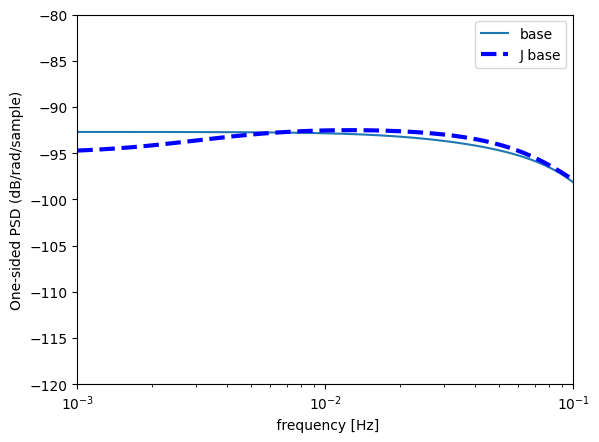

In [182]:
order_a = 1
order_b = 3
ar_base, b_base, rho_base= spectrum.arma_estimate(x, order_a, order_b, lag=12)
PSD_base = spectrum.arma2psd(A = ar_base, B = b_base, rho = rho_base, T = 0.4, NFFT=512) 
PSD_base = PSD_base[:len(PSD_base)//2]*2 #per convenzione se diemzzo l'intervallo devo raddoppiare i valori così 
                                        #l'area sottesa corrisponde sempre alla variaza totale
plt.semilogx(np.linspace(0, 0.2, len(PSD_base)),10*np.log10(abs(PSD_base)),label='base')
#plt.plot(np.linspace(0, 0.2, len(PSD_base)), abs(PSD_base)),
 #   label='base')

plt.semilogx(dati_clean['m_base']['F'], signals['m_base']['spettro_clean'], color = 'b', linestyle = '--', label ='J base', linewidth = 3)

plt.xlabel(' frequency [Hz]')
plt.ylabel('One-sided PSD (dB/rad/sample)')
plt.legend() 
plt.xlim(0.001, 0.1)
plt.ylim([-120, -80])

Mi riduco a confrontare i due modelli migliori

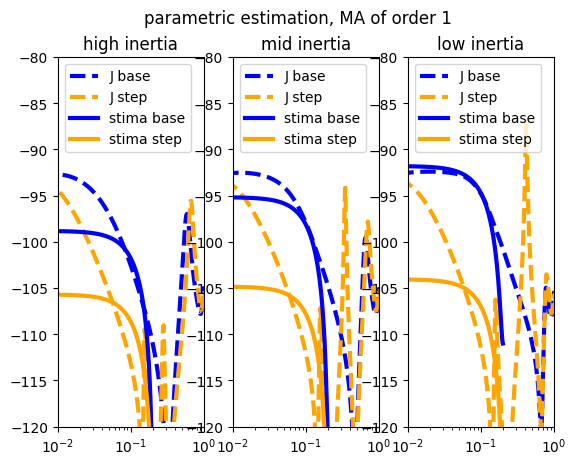

In [18]:
# MA
order = 1
f_vect = np.linspace(0, 0.2, 256)
for k in signals.keys():
    B, rho = spectrum.ma(signals[k]['omega_downsample'], Q = order, M = 10)
    PSD = spectrum.arma2psd(A = None, B = B, rho = rho, T = 0.4, NFFT=512) 
    #signals[k]['spettro_parametric'] = abs(PSD[:len(PSD)//2]*2)
    signals[k]['spettro_parametric'] = 10*np.log10(abs(PSD[:len(PSD)//2]*2))
fig, axs = plt.subplots(1,3)
xlim = (0.01, 1)
ylim = (-120, -80)
axs[0].semilogx(dati_clean['h_base']['F'], signals['h_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[0].semilogx(dati_clean['h_step']['F'], signals['h_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[0].semilogx(f_vect, signals['h_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[0].semilogx(f_vect, signals['h_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].set_title('high inertia')
axs[0].legend(loc = 'upper left')

axs[1].semilogx(dati_clean['m_base']['F'], signals['m_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[1].semilogx(dati_clean['m_step']['F'], signals['m_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[1].semilogx(f_vect, signals['m_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[1].semilogx(f_vect, signals['m_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].set_title('mid inertia')
axs[1].legend(loc = 'upper left')

axs[2].semilogx(dati_clean['l_base']['F'], signals['l_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[2].semilogx(dati_clean['l_step']['F'], signals['l_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[2].semilogx(f_vect, signals['l_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[2].semilogx(f_vect, signals['l_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
axs[2].set_title('low inertia')
axs[2].legend(loc = 'upper left')
plt.suptitle('parametric estimation, MA of order {}'.format(order))
plt.show()

plt.show()                                                      

Quest stime non sono un granché. Proviamo adesso con il modello autoregressivo. Il criterio di Akaike suggerisce un ordine 3, io ho provato i vari ordini e sotto vedete il miglior risultato: AR(3)

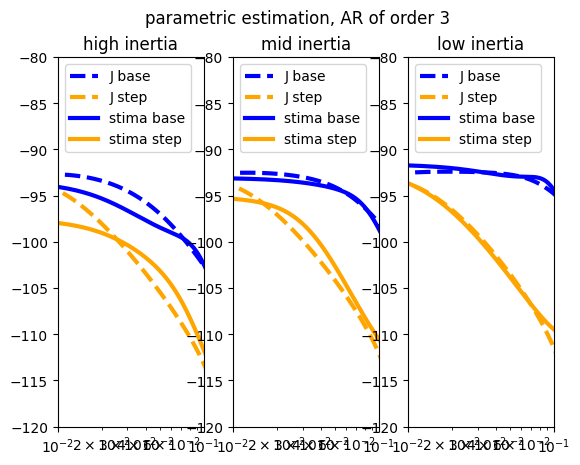

In [19]:
# AR(3)
order = 3
f_vect = np.linspace(0, 0.2, 256)
for k in signals.keys():
    AR, P, refl = spectrum.arburg(signals[k]['omega_downsample'], order)
    PSD = spectrum.arma2psd(AR, rho = P, T = 0.4, NFFT=512) 
    #signals[k]['spettro_parametric'] = abs(PSD[:len(PSD)//2]*2)
    signals[k]['spettro_parametric'] = 10*np.log10(abs(PSD[:len(PSD)//2]*2))
fig, axs = plt.subplots(1,3, figsize=(12,8))
xlim = (0.01, 0.1)
ylim = (-120, -80)
axs[0].semilogx(dati_clean['h_base']['F'], signals['h_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[0].semilogx(dati_clean['h_step']['F'], signals['h_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[0].semilogx(f_vect, signals['h_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[0].semilogx(f_vect, signals['h_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].set_title('high inertia')
axs[0].legend(loc = 'upper left')

axs[1].semilogx(dati_clean['m_base']['F'], signals['m_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[1].semilogx(dati_clean['m_step']['F'], signals['m_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[1].semilogx(f_vect, signals['m_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[1].semilogx(f_vect, signals['m_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].set_title('mid inertia')
axs[1].legend(loc = 'upper left')

axs[2].semilogx(dati_clean['l_base']['F'], signals['l_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[2].semilogx(dati_clean['l_step']['F'], signals['l_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[2].semilogx(f_vect, signals['l_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[2].semilogx(f_vect, signals['l_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
axs[2].set_title('low inertia')
axs[2].legend(loc = 'upper left')
plt.suptitle('parametric estimation, AR of order {}'.format(order))
plt.show()
plt.tight_layout()

plt.show()                                                      

Infine, proviamo anche il modello arma ma potete provare a variare i parametri p e q, otterrette spettri non tanto migliori a parte per la configurazione (1,1) e se provate a modificare i parametri si forma un picco di risonanza molto diverso da quello del jacobiano

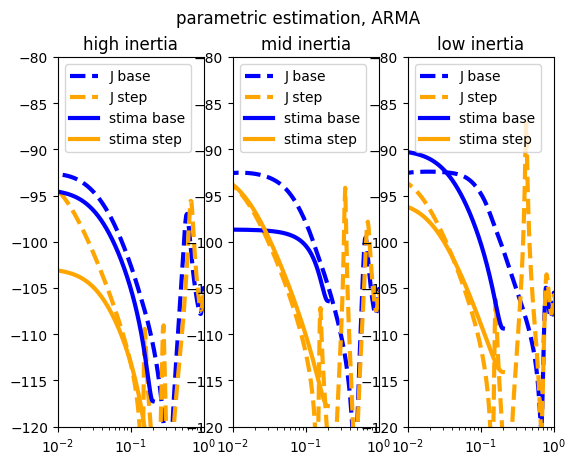

In [13]:
# ARMA
autoregressive_order = 1
movingaverage_order = 1
f_vect = np.linspace(0, 0.2, 1024)
for k in signals.keys():
    a, b, rho = spectrum.arma_estimate(signals[k]['omega_downsample'],P=autoregressive_order, Q = movingaverage_order, lag = 5)
    PSD = spectrum.arma2psd(A = a, B = b, rho = rho, T = 0.4, NFFT=2048) 
    #signals[k]['spettro_parametric'] = abs(PSD[:len(PSD)//2]*2)
    signals[k]['spettro_parametric'] = 10*np.log10(abs(PSD[:len(PSD)//2]*2))
fig, axs = plt.subplots(1,3)
xlim = (0.01, 1)
ylim = (-120, -80)
axs[0].semilogx(dati_clean['h_base']['F'], signals['h_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[0].semilogx(dati_clean['h_step']['F'], signals['h_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[0].semilogx(f_vect, signals['h_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[0].semilogx(f_vect, signals['h_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].set_title('high inertia')
axs[0].legend(loc = 'upper left')

axs[1].semilogx(dati_clean['m_base']['F'], signals['m_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[1].semilogx(dati_clean['m_step']['F'], signals['m_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[1].semilogx(f_vect, signals['m_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[1].semilogx(f_vect, signals['m_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].set_title('mid inertia')
axs[1].legend(loc = 'upper left')

axs[2].semilogx(dati_clean['l_base']['F'], signals['l_base']['spettro_clean'], color = 'b', linestyle = '--', 
        label ='J base', linewidth = 3)
axs[2].semilogx(dati_clean['l_step']['F'], signals['l_step']['spettro_clean'], color = 'orange', linestyle = '--',
        label ='J step', linewidth = 3)
axs[2].semilogx(f_vect, signals['l_base']['spettro_parametric'], color = 'b', linestyle = '-', 
        label ='stima base', linewidth = 3)
axs[2].semilogx(f_vect, signals['l_step']['spettro_parametric'],color = 'orange', linestyle = '-', 
        label ='stima step', linewidth = 3)
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
axs[2].set_title('low inertia')
axs[2].legend(loc = 'upper left')
plt.suptitle('parametric estimation, ARMA')
plt.show()

plt.show()                                                      

## Conclusioni
Per le stime parametriche risulta che il modello migliore sia un AR(3) oppure un ARMA(1,1). Ciò non sorprende perché in molti casi pratici stimare lo spettro risulta più comodo con i modelli autoregressivi che si concentrano molto nell'approssimare i picchi di interesse. Al contrario la parte a media mobile tende a concentrarsi sulle valli dello spettro. Nel nostro caso infatti ci vogliamo concentrare sull'identificare correttamente il picco in bassa frequenza e il suo intorno.
Sarà da valutare quale di questi ci consente di avere una stima migliore, nel frattempo produco un dataset e valutiamo i risultati.
Inoltre qualunque metodo fornisce lo stesso risultato se applicato ai 10 generatori quindi purtroppo è abbastanza inutile mettere nel training set gli spettri di più generatori.